
## Ridge Regression

### I. Deriving the Weight Update Steps of (Stochastic) Gradient Descent

Our linear regression model is defined by $$y(\mathbf{x},\mathbf{w}) = \mathbf{w}\cdot\mathbf{\boldsymbol{\phi}({x})}$$ where $\mathbf{x}$ is the input data in the form of training data $(\mathbf{x}_1, t_1), \dots, (\mathbf{x}_N, t_N) \in \mathbb{R}^M \times \mathbb{R}$ and $\mathbf{\boldsymbol{\phi}(\mathbf{x})}=(\phi_1(\mathbf{x}), \dots, \phi_p(\mathbf{x}))$ is the basic function vector.

In linear regression, we want to set the parameter vector $\mathbf{w} \in \mathbb{R}^p$ so that the prediction $y(\mathbf{x},\mathbf{w})$ aligns with target value in training data. To fit the model, we minimize the mean of squared errors. Since we are doing Ridge regression, the error function has L2 norm regularization and is given by

$$\begin{align*} E(\mathbf{w}) &= \frac{1}{2n} \sum_{n=1}^{N} \left( t_n - \mathbf{w} \cdot\boldsymbol{\phi}(x_n)\right)^2 + \frac{\lambda}{2} \sum_{j=0}^{M-1} w_j^2\\
&= \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2 + \frac{\lambda}{2} \| \mathbf{w} \|^2
\end{align*} $$ 

where $\lambda$ is the regularization parameter.

#### Gradient Derivation
From the regularized error function above, we take derivative with respect to $\mathbf{w}$ and get 

$$\nabla E(\mathbf{w}) = \frac{1}{n} \Phi^\top(\Phi \mathbf{w} - \mathbf{t}) \enspace  + \lambda \mathbf{w}$$

#### Weight Update Step
By setting the above gradient function to zero-vector and solving for $\mathbf{w}$, we obtain the weight update step for iteration number $\tau=1, 2, \dots$ and learning rate parameter $\eta^{(\tau)}$ as follows:

##### 1. Standard batch Gradient Descent (GD)

The weight update step is given by
$$ \mathbf{w}^{(\tau)} = \mathbf{w}^{(\tau-1)} - \eta^{(\tau)} \left( \frac{1}{n} \Phi^\top (\Phi \mathbf{w}^{(\tau-1)} - \mathbf{t}) + \lambda \mathbf{w}^{(\tau-1)} \right) $$

##### 2. Single sample $(x_n, t_n)$ Stochastic Gradient Descent (SGD)

The instantaneous error function is:

$$E_n(\mathbf{w}) = \frac{1}{2} \left( t_n - \mathbf{w}^\top \boldsymbol{\phi}(x_n) \right)^2 + \frac{\lambda}{2} \| \mathbf{w} \|^2$$


Its gradient is:

$$\nabla E_n(\mathbf{w}) = - \left( t_n - \mathbf{w}^\top \boldsymbol{\phi}(x_n) \right) \boldsymbol{\phi}(x_n) + \lambda \mathbf{w}$$

Thus, the SGD update rule becomes:

$$\mathbf{w}^{(\tau)} = \mathbf{w}^{(\tau-1)} + \eta^{(\tau)} \left[ \left( t_n - \mathbf{w}^{(\tau-1)\top} \boldsymbol{\phi}(x_n) \right) \boldsymbol{\phi}(x_n) - \lambda \mathbf{w}^{(\tau-1)} \right]$$

Where the value of $\mathbf{w}$ is initialised to some starting vector $\mathbf{w}^{(0)}$.

### II. Implementing a Gradient Descent Algorithm for Ridge Regression

Following the deriving of the weight update step above, I use the Gradient Descent to implement Ridge regression model. I follow similar convention as the `scikit-learn` skeleton for Gradient Descent Linear regressor, but with the added regularization term:
- in the `__init__` method, I initialize some additional hyper parameters, `'lambda_'` as the regularization term and `'initial_w'` as the initial guess $\mathbf{w}^{(0)}$
- in the `fit` method I added the added regularization term in the `'grad'` step

In [ ]:
import numpy as np

class GDLinearRegressor:

    def __init__(self, initial_w = None, eta=0.01, tau_max=10000, epsilon=1e-6, lambda_=None):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.initial_w = initial_w
        
    def fit(self, x, y):
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max + 1, p))
        # Initialize weight in case there is an initial guess other than zero vector
        self.w_[0] = self.initial_w if self.initial_w is not None else np.zeros(p)
        
        for tau in range(1, self.tau_max + 1):
            grad = x.T.dot(x.dot(self.w_[tau - 1]) - y) / n + self.lambda_ * self.w_[tau - 1]
            self.w_[tau] = self.w_[tau - 1] - self.eta * grad
            # stopping criterion
            if np.linalg.norm(self.w_[tau] - self.w_[tau - 1]) < self.epsilon:
                break

        # set final coefficients
        self.coef_ = self.w_[tau]
        # delete unused rows from weight matrix
        self.w_ = self.w_[:tau + 1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)

### III. Study the Effect of L2-Regularization Term

In this section, using a synthetic data generator I generate data with the following distributions:

$X \sim \text{Uniform}(-0.3,0.3)$

$Y = \frac{\text{cos}(3\pi x)}{2+3x}+\epsilon,\,\,\,\,\epsilon \sim \text{N}(0, 0.1)$

The regularization term used is defined as follows

$\lambda \in \{10^{-10+9i/100},\dots, 10^{-1}: 0\leq i\leq 100\}$.

The steps I take in the below experiment is as follows:
- Generate the test and train dataset individually, using the data generator `make_additive_noise_data`.
- Fit the model ten times for each lambda by making a pipeline of the ridge regressor and a polynomial feature transformer of degree 5 using `PolynomialFeatures`. From the training dataset, resample 20 of them for each repetition, making sure every lambda have the same training dataset each time.
- Compute the train and test error and store them accordingly.
- Plot the mean squared errors of both training and test with log scaling.

In [20]:
import numpy as np

def f(x):
    return np.cos(3*np.pi*x)/(2+3*x)

def make_additive_noise_data(n, f, a, b, noise=0.1**0.5, random_state=None):
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

lambda_ = np.geomspace(10**-10,0.1, 101, endpoint=True)

n_repeats = 10  # number of times to resample training data
train_size = 20
test_size = 1000 # for sampling a large amount of independent test data

train_errors = np.zeros((n_repeats, len(lambda_)))
test_errors = np.zeros((n_repeats, len(lambda_)))

# Generate the test set once
x_test, y_test = make_additive_noise_data(test_size, f, -0.3, 0.3, random_state=25)
x_train, y_train = make_additive_noise_data(train_size*n_repeats, f, -0.3, 0.3, random_state=26)

for i in range(n_repeats):
    # Resample training data
    idx = np.random.choice(x_train.shape[0],train_size,replace=True)
    x_train_resampled = x_train[idx]
    y_train_resampled = y_train[idx]

    for j, lam in enumerate(lambda_):
        # Create and fit model
        poly = PolynomialFeatures(degree=5)
        linear = GDLinearRegressor(lambda_ = lam)
        model = make_pipeline(poly, linear)
        model.fit(x_train_resampled, y_train_resampled.ravel())  # .ravel() ensures target is 1D

        # Compute and store train and test errors
        y_train_pred = model.predict(x_train_resampled)
        y_test_pred = model.predict(x_test)

        train_errors[i, j] = np.mean((y_train_pred - y_train_resampled.ravel())**2)
        test_errors[i, j] = np.mean((y_test_pred - y_test.ravel())**2)

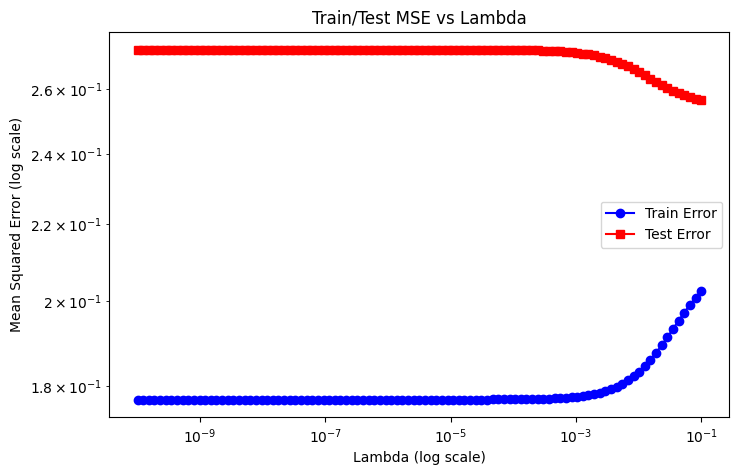

In [ ]:
mean_train_errors = train_errors.mean(axis=0)
mean_test_errors = test_errors.mean(axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Plot log(lambda) vs log(MSE)
plt.plot(lambda_, mean_train_errors, label='Train Error', color='blue', marker='o')
plt.plot(lambda_, mean_test_errors, label='Test Error', color='red', marker='s') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Train/Test MSE vs Lambda')
plt.legend()
plt.show()

#### Analysis

For this amount of iteration and learning rate, model seems to be overfitting for small $\lambda$. It makes sense because for small $\lambda$ the Ridge regression is similar to ordinary least squares, thus training MSE would be at its lowest. 

However, as the lambda increases, both error increases as well, showing no sign of stabilizing yet. There should be more movement especially on the test error, (i.e. there should be an area where it minimizes), to find the area where there's good bias-variance tradeoff.

This could be caused by the use of the polynomial transformer that has a high degree, thus resulting in the regressor to get "stuck" at local minima instead of global minima. Additionally it might be caused by the initial guess of the weight being too far from the global minima.

Thus I extended the experiment by using closed form solution of the Ridge regression describe below.

## Using Closed From Ridge Regression Solution

I implemented `RidgeClosedForm`, where I try to find the weight analytically. Then I use this weight plus some "noise" as the initial weight for the original ridge regressor `GDLinearRegressor`. This is why I implemented `'initial_w'` in my original ridge regressor. Then following the exact same steps as the experiment above, I got the result in the plot below. 

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

# Store training and testing errors
train_errors_ridge = np.zeros((n_repeats, len(lambda_)))
test_errors_ridge = np.zeros((n_repeats, len(lambda_)))

# Implement the closed form solution solver to obtain the weight

class RidgeClosedForm(BaseEstimator):
    def __init__(self, lam=None):
        self.lam = lam
        self.coef_ = None
    
    def fit(self, X, y):
        n, p = X.shape
        I = np.eye(p)
        A = X.T.dot(X) + n* self.lam * I
        b = X.T.dot(y)
        self.coef_ = np.linalg.solve(A, b)
        return self
    
    def predict(self, X):
        return X.dot(self.coef_)
    
for i in range(n_repeats):
    # Resample training data
    idx = np.random.choice(x_train.shape[0],size=train_size,replace=True)
    x_train_resampled = x_train[idx]
    y_train_resampled = y_train[idx]

    for j, lam in enumerate(lambda_):
        # Create and fit model
        model_ridge = Pipeline([
        ('poly', PolynomialFeatures(5)),
        ('ridge', RidgeClosedForm(lam=lam))
        ])
        model_ridge.fit(x_train_resampled,y_train_resampled.ravel())
        
        # Use the weight from the closed-form solution plus some noise as the 
        # initial guess of the weight
        linear_ridge = GDLinearRegressor(
            lambda_ = lam, 
            initial_w = model_ridge['ridge'].coef_ - 0.8)
        poly = PolynomialFeatures(degree=5)
        model_linear_ridge = make_pipeline(poly,linear_ridge)
        model_linear_ridge.fit(x_train_resampled, y_train_resampled.ravel())

        # Compute and store train and test errors
        y_train_pred_ridge = model_linear_ridge.predict(x_train_resampled)
        y_test_pred_ridge = model_linear_ridge.predict(x_test)

        train_errors_ridge[i, j] = np.mean((y_train_pred_ridge - y_train_resampled.ravel())**2)
        test_errors_ridge[i, j] = np.mean((y_test_pred_ridge - y_test.ravel())**2)


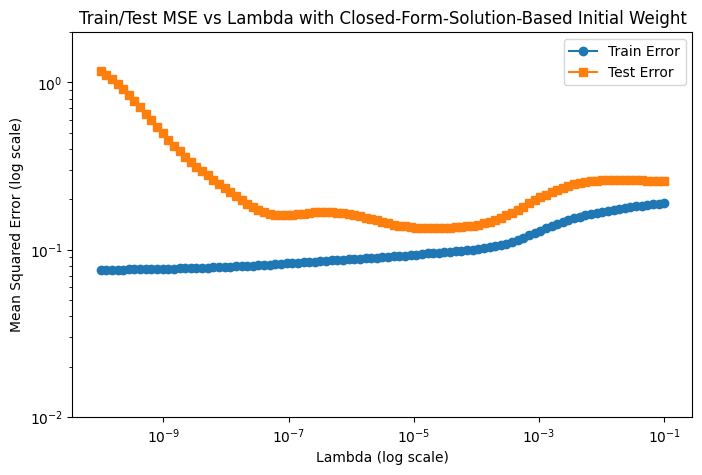

In [ ]:
mean_train_errors_r = train_errors_ridge.mean(axis=0)
mean_test_errors_r = test_errors_ridge.mean(axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot log(lambda) vs log(MSE)
plt.plot(lambda_, mean_train_errors_r, label='Train Error', marker='o')
plt.plot(lambda_, mean_test_errors_r, label='Test Error', marker='s')
plt.ylim(1e-2,2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Train/Test MSE vs Lambda with Closed-Form-Solution-Based Initial Weight')
plt.legend()
plt.show()

### Analysis

The performance of the errors are much more visible and observable in this experiment:
- When the $\lambda$ is small (e.g < $10^{-8}$), the model is barely regularized. The test error is high while the train error is at its lowest, showing a sign of overfitting
- As the $\lambda$ increases (e.g. between $10^{-8}$ and $10^{-4}$), there is a balance between train and test error as the train error monotonically increases while the test error minimizes
- When the $\lambda$ is high (e.g > $10^{-4}$), regularization dominates. Since regularization limits the effective model complexity, if the regularization is too much ($\lambda$ is too high), then the model becomes too simple and can't capture the underlying data pattern, thus underfitting the data. 

### Conclusion

This experiment confirms the hypothesis in the previous experiment that the algorithm is sensitive to the initial guess, especially with high degree polynomial features transformer. It also highlights the crucial role of L2 regularization in controlling model complexity and achieving optimal generalization. By varying $\lambda$, we observe a clear trade-off between bias and variance:

- Small $\lambda$ values lead to overfitting, with low training error but poor generalization.

- Medium $\lambda$ achieves the best performance on unseen data, balancing fit and simplicity.

- Large $\lambda$ over-penalizes model flexibility, resulting in underfitting and increased errors.

Thus, careful selection of the regularization parameter is essential in building robust models that perform well not just on training data, but also on new, unseen data.

